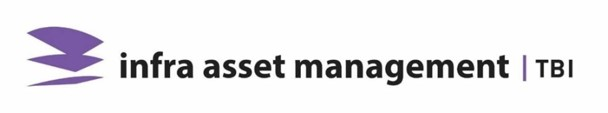

In [1]:
import os
import json
import asyncio

import pandas as pd

import ipywidgets as widgets 
from ipywidgets import interact, interact_manual, Layout

import time
from datetime import datetime

from storingsanalyse import StoringsAnalyse

In [2]:
# Class zorgt ervoor dat een waarde meegegeven kan worden aan een Button
import traitlets
class LoadedButton(widgets.Button):
    """A button that can holds a value as a attribute."""

    def __init__(self, value=None, *args, **kwargs):
        super(LoadedButton, self).__init__(*args, **kwargs)
        # Create the value attribute.
        self.add_traits(value=traitlets.Any(value))


# Aparte functie voor het wachten op verandering (aka input van de ME)
def wait_for_change(widget):
    future = asyncio.Future()
    def getvalue(change):
        future.set_result(change.description)
        widget.on_click(getvalue, remove=True) 
        # we need to free up the binding to getvalue to avoid an InvalidState error
        # buttons don't support unobserve
        # so use `remove=True` 
    widget.on_click(getvalue)
    return future

In [3]:
""" In the line bellow fill in your API key without < and > """ 
api_key = 'bWF4YWRtaW46R21iQ1dlbkQyMDE5' # provided to you by a Maximo Consultant

""" In the line bellow fill in the desired object structure """
obj_struct = 'MXWO_SND' # name of the Maximo object structure

""" In the line bellow fill in the PO number and the SITEID without the < and > """
query = 'siteid="CT1EN2" and worktype="COR" and reportdate>="2018-01-01T00:00:00-00:00" and reportdate<="2018-03-30T00:00:00-00:00"'

# Voorbereiding

In de voorbereiding wordt u gevraagd het volgende te specificeren:
    - Het project waarvoor de storingsanalyse wordt uitgevoerd.
    - Uw API Key.
    - De object structuur.
    
NOTE: 

Er moeten wat invoervelden worden toegevoegd. Hier gaat het om een selectie van of dit een jaar of Qx rapportage gaat worden en indien het een Qx rapportage wordt, ook specificeren om welke datums/welke Q het rapport betrekking heeft. 

Bij het invoeren van de query moet de invoer manier anders. Hier staat nog een tekst-invoerveld, maar dit moet dit getimmerd worden tot het punt dat de drie parameters van de query ingevuld kunnen worden door klikken en een meer low-code UI.

https://github.com/microsoft/vscode-jupyter/issues/1015 geeft misschien fix voor widgets die niet getoont kunnen worden bij opstart.

In [4]:
input_project = widgets.Dropdown(
    options=["Coentunnel-tracé", "Sluis Eefde"],
    value="Coentunnel-tracé",
    description='Project:',
    disabled=False,
)

input_api_key = widgets.Text(
    value='bWF4YWRtaW46R21iQ1dlbkQyMDE5',
    placeholder='Type something',
    description='API key:',
    disabled=False,
    layout=Layout(width='50%')
)

input_obj_struct = widgets.Text(
    value='MXWO_SND',
    placeholder='Type something',
    description='Object Structuur:',
    disabled=False,
    layout=Layout(width='50%'),
    style=dict(description_width='initial')
)

display(input_project, input_api_key, input_obj_struct)

Dropdown(description='Project:', options=('Coentunnel-tracé', 'Sluis Eefde'), value='Coentunnel-tracé')

Text(value='bWF4YWRtaW46R21iQ1dlbkQyMDE5', description='API key:', layout=Layout(width='50%'), placeholder='Ty…

Text(value='MXWO_SND', description='Object Structuur:', layout=Layout(width='50%'), placeholder='Type somethin…

In [5]:
input_start_date = widgets.DatePicker(
    description='Start date',
    disabled=False
)

input_end_date = widgets.DatePicker(
    description='End date',
    disabled=False
)

display(input_start_date, input_end_date)

DatePicker(value=None, description='Start date')

DatePicker(value=None, description='End date')

In [6]:
# Instance van LoadedButton
button = LoadedButton(description='Start', value=False)

# Functie voor start input
async def start_function():
    print('Waiting for input')
    a = await wait_for_change(button)  # Wachter gebeurt o.a. hierdoor 
    button.value = True
    if button.value:
        sa = StoringsAnalyse(input_project.value, input_api_key.value, input_obj_struct.value)
        print(sa.project)  # om te checken of een instance gemaakt is van StoringsAnalyse

asyncio.create_task(start_function())

display(button)

LoadedButton(description='Start', style=ButtonStyle())

Waiting for input


# Bevragen van de Maximo Database
Het bevragen van de database wordt gedaan door middel van het invoeren van de query die u naar de database wilt sturen.

In [7]:
input_query = widgets.Textarea(
    value="""Type your query here.""",
    placeholder='Type something',
    description='Query:',
    disabled=False,
    layout = Layout(width='60%', height='80px')
)
display(input_query)

Textarea(value='Type your query here.', description='Query:', layout=Layout(height='80px', width='60%'), place…

In [8]:
# Instance van LoadedButton
button = LoadedButton(description='Query database', value=False)

# Functie voor start input
async def query_function():
    print('Waiting for a sign to query the Maximo Database')
    a = await wait_for_change(button)  # Wachter gebeurt o.a. hierdoor 
    button.value = True
    if button.value:
        query = input_query.value
        print(f'Het uitvoeren van de query moet nog worden getest. De query die gebruikt wordt is:\n"{query}"')
#         sa.get_maximo_export(query=query)
#         sa.response_data

asyncio.create_task(query_function())

display(button)

LoadedButton(description='Query database', style=ButtonStyle())

Waiting for a sign to query the Maximo Database


# Bouwen van de staging file
Voordat de storingsanalyse uitgevoerd moet worden vraagt het om een manuele actie van de maintenance engineers. In de staging file die hier gegenereerd wordt, moet een onderscheid gemaakt worden tussen de regels op basis van het type van de melding. 

In [9]:
# Toegevoegd om stap 2 buitenspel te zetten tijdens tests
sa.filename_saved_response_data = 'raw_json_payload.json'

NameError: name 'sa' is not defined

In [ ]:
button = widgets.Button(description="Generate staging file")
output = widgets.Output()
display(button, output)

def on_click(a):
    with output:
        sa.build_staging_file(sa.filename_saved_response_data)
        print(f"Staging file saved as {sa.staging_filename} in the folder 'staging file'.")

button.on_click(on_click)

In [ ]:
sa.build_staging_file(sa.filename_saved_response_data)

In [ ]:
sa.staging_filename

## Importeren van de staging_file

De staging file geeft ruimte aan de maintenance engineers om de verschillende meldingen te categoriseren als 'Onterecht', 'Preventief', 'Storing' of 'Incident'.

In [ ]:
sa.read_staging_file(filename=sa.filename_saved_response_data)

In [ ]:
sf_data = sa.staging_file_data

### Aanpassen van de staging_file -- DEZE STAP WORDT VERWIJDERD IN DE TOEKOMST
Het opbouwen van deze automatische storingsanalyse vraagt om een ingevulde kolom 'type melding'. Om het process van opbouwen niet te laten stagneren op dit aspect, wordt er hieronder fictive data gegenereerd. Met behulp van de fictieve data wordt het genereren van de verschillende tabellen en grafieken gebouwd.

In [ ]:
from random import randrange

lijst_opties = ['Storing', 'Incident', 'Preventief', 'Onterecht']

random_ranges = [lijst_opties[randrange(0, 4, 1)] for _ in range(len(sf_data['type melding (Storing/Incident/Preventief/Onterecht)']))]

print(len(random_ranges) == len(sf_data['type melding (Storing/Incident/Preventief/Onterecht)']))

sf_data.loc[:, 'type melding (Storing/Incident/Preventief/Onterecht)'] = random_ranges

random_ranges[:10]

In [ ]:
import numpy as np
lijst_opties = ['P01', 'P02', 'P03', 'P04', 'P05', 'P06', 'P07', 'P08', 'P09', 'P10', 'P11', np.nan]

random_ranges = [lijst_opties[randrange(0, len(lijst_opties), 1)] for _ in range(len(sf_data['probleem code']))]

print(len(random_ranges) == len(sf_data['probleem code']))

sf_data.loc[:, 'probleem code'] = random_ranges

random_ranges[:10]

In [ ]:
lijst_opties = ['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 
                'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', np.nan]

random_ranges = [lijst_opties[randrange(0, len(lijst_opties), 1)] for _ in range(len(sf_data['oorzaak code']))]

print(len(random_ranges) == len(sf_data['oorzaak code']))

sf_data.loc[:, 'oorzaak code'] = random_ranges

random_ranges[:10]

In [ ]:
lijst_opties = ['S01', 'S02', 'S03', 'S04', 'S05', 'S06', 'S07', 'S08', np.nan]

random_ranges = [lijst_opties[randrange(0, len(lijst_opties), 1)] for _ in range(len(sf_data['oplos code']))]

print(len(random_ranges) == len(sf_data['oplos code']))

sf_data.loc[:, 'oplos code'] = random_ranges

random_ranges[:10]

In [ ]:
sf_data.iloc[:5, 15:25]

# Analyse

## Aantal meldingen per maand